### This is a speech recognition script using tensorflow

Used imports below.

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import time
import tensorflow_io as tfio

from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


### Fetch datasets from created directories

In [53]:

# Fetch the sampling rate and shape of the signals
audio_file = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_training_set/97/common_voice_fi_23642710.wav"

signal, sr = librosa.load(audio_file, sr=None)
batch_size = 32
print(signal.shape, sr)

train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_training_set/",
    labels='inferred',
    label_mode='int',
    output_sequence_length=signal.shape[0],
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
)

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_validation_set/",
    labels='inferred',
    label_mode='int',
    output_sequence_length=signal.shape[0],
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
)

label_names = np.array(train_ds.class_names)
val_ds



(32000,) 16000
Found 4725 files belonging to 26 classes.
Found 1169 files belonging to 26 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Delete channel from audio data (not needed here)

In [54]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Split the validation set into test set and learning validation set

In [55]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Examples from the training set

In [56]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)


(32, 32000)
(32,)


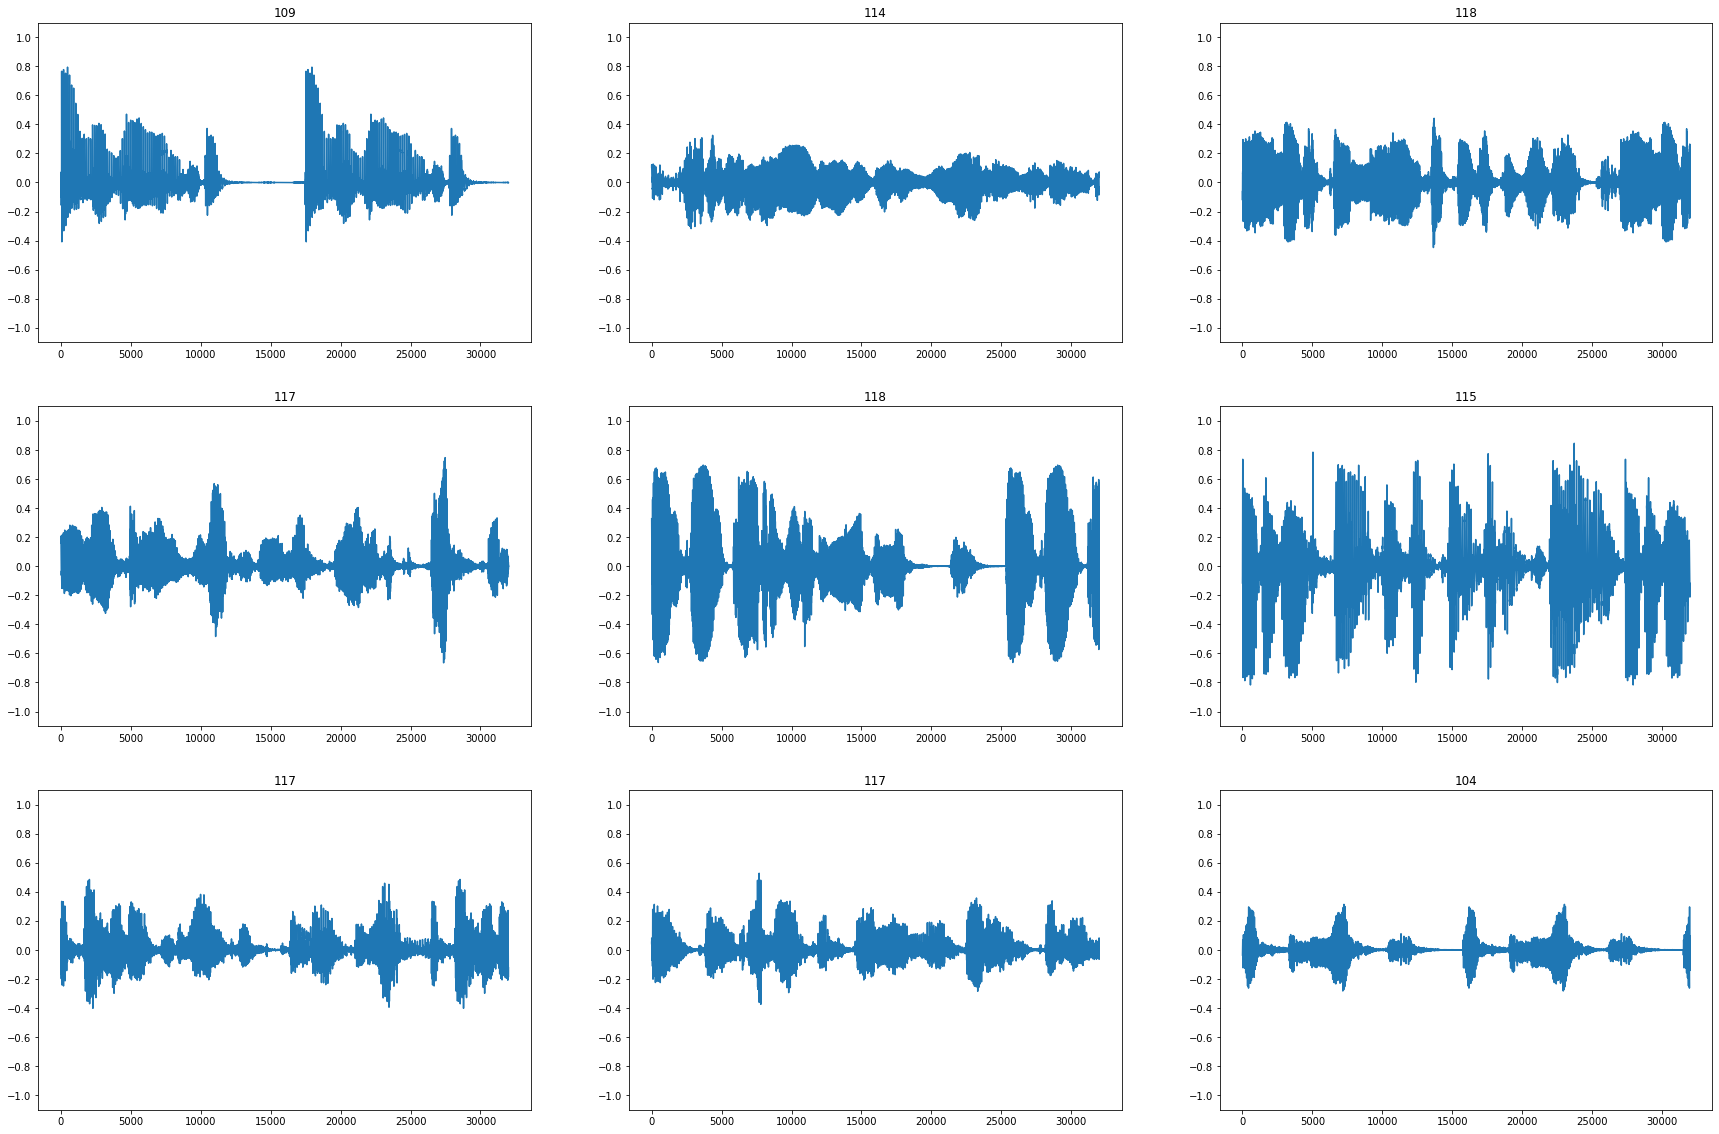

In [57]:
rows = 3
cols = 3
n = rows * cols
with plt.rc_context({'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor': 'white'}):
  fig, axes = plt.subplots(rows, cols, figsize=(30, 20))

for i in range(n):
  if i >= n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1, 1.1])

plt.show()


Function to transform signals into MFCC-spectrograms

In [58]:

def get_spectrogram(waveform):
   stfts = tf.signal.stft(
       waveform, frame_length=1024, frame_step=256,
       fft_length=1024)
   # Obtain the magnitude of the STFT.
   spectrograms = tf.abs(stfts)

   mel_spectrograms = tfio.audio.melscale(
       spectrograms, rate=sr, mels=128, fmin=0, fmax=8000)

   # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
   log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

   # Compute MFCCs from log_mel_spectrograms and take the first 13.
   mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :13]
   mfccs = tf.expand_dims(mfccs, axis=-1)
   return mfccs 


Examples of the transformation

In [59]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=sr))

Label: 109
Waveform shape: (32000,)
Spectrogram shape: (122, 13, 1)
Audio playback


Label: 114
Waveform shape: (32000,)
Spectrogram shape: (122, 13, 1)
Audio playback


Label: 118
Waveform shape: (32000,)
Spectrogram shape: (122, 13, 1)
Audio playback


In [60]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    spectrogram = spectrogram.T
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, signal.shape[0], num=width, dtype=int)
    Y = range(height)
    img = ax.pcolormesh(X, Y, spectrogram, cmap=mpl.cm.cool)
    return img



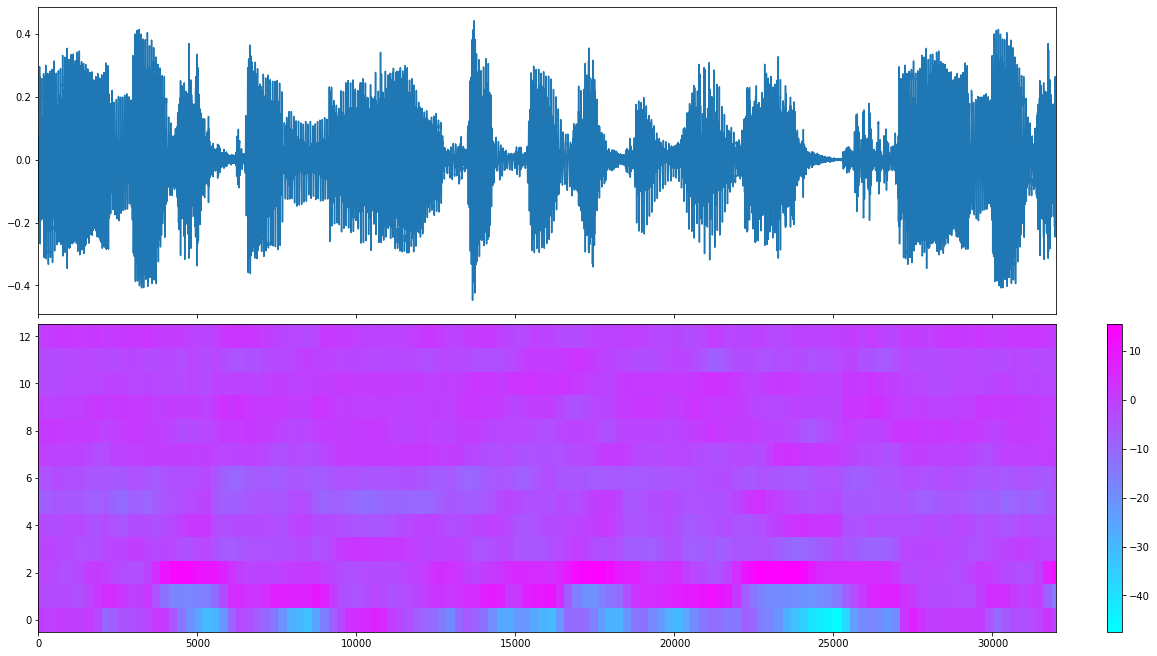

In [61]:
with plt.rc_context({'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor': 'white'}):
    fig, axes = plt.subplots(2, figsize=(16,9), constrained_layout=True, sharex=True)
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy())
    #axes[0].set_title('Signaali')
    axes[0].set_xlim([0, signal.shape[0]])
    

    img = plot_spectrogram(spectrogram.numpy(), axes[1])
    #axes[1].set_title('Spektrogrammi')
    fig.colorbar(img)
    plt.show()


Utility function to transform the whole TF.dataset into a spectrogram form

In [62]:
shape = spectrogram.get_shape().as_list()
def make_spec_ds(audio, label):
      spec = get_spectrogram(audio)
      spec.set_shape([None, *shape])
      spec = tf.image.resize(spec, (32,32))
      print(spec)
      return spec, label


Transformation of the datasets

In [63]:
train_spectrogram_ds = train_ds.map(make_spec_ds, tf.data.AUTOTUNE)
val_spectrogram_ds = val_ds.map(make_spec_ds, tf.data.AUTOTUNE)
test_spectrogram_ds = test_ds.map(make_spec_ds, tf.data.AUTOTUNE)

print(train_spectrogram_ds)
print(val_spectrogram_ds)
print(test_spectrogram_ds)



Tensor("resize/ResizeBilinear:0", shape=(None, 32, 32, 1), dtype=float32)
Tensor("resize/ResizeBilinear:0", shape=(None, 32, 32, 1), dtype=float32)
Tensor("resize/ResizeBilinear:0", shape=(None, 32, 32, 1), dtype=float32)
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [64]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [65]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)



Saving the testing data into a numpy form for later use, might need to manually reconfigure the sizes etc. in your use case.

In [ ]:


test_np = tfds.as_numpy(test_spectrogram_ds.unbatch())

test_X = np.empty((593, 32, 32, 1))
test_Y = np.empty(593)
i = 0
for spec, label in test_np:
  test_X[i] = spec
  test_Y[i] = label
  i += 1


print(test_X, test_Y)
np.save("./test_X.npy", test_X)
np.save("./test_Y.npy", test_Y)



## Creation of the Keras model

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print(num_labels)


model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(4, 3, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l1(0.0001), kernel_initializer='lecun_uniform', name="conv_1"),
    layers.BatchNormalization(name="bn_1"),
    layers.MaxPooling2D(pool_size=(2, 2), name="mp_1"),

    layers.Conv2D(4, 3, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l1(0.0001), kernel_initializer='lecun_uniform', name="conv_2"),
    layers.BatchNormalization(name="bn_2"),
    layers.MaxPooling2D(pool_size=(2, 2), name="mp_2"),

    layers.Conv2D(12, 3, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l1(0.0001), kernel_initializer='lecun_uniform', name="conv_3"),
    layers.BatchNormalization(name="bn_3"),
    layers.MaxPooling2D(pool_size=(2, 2), name="mp_3"),
    layers.Flatten(name='flatten'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l1(0.0001), kernel_initializer='lecun_uniform', name="dense_1"),
    layers.Dense(num_labels, activation='softmax', name="output_dense"),
], name="CNN_1")
model.summary()




Input shape: (32, 32, 1)
35
Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 4)         40        
                                                                 
 bn_1 (BatchNormalization)   (None, 30, 30, 4)         16        
                                                                 
 mp_1 (MaxPooling2D)         (None, 15, 15, 4)         0         
                                                                 
 conv_2 (Conv2D)             (None, 13, 13, 4)         148       
                                                                 
 bn_2 (BatchNormalization)   (None, 13, 13, 4)         16        
                                                                 
 mp_2 (MaxPooling2D)         (None, 6, 6, 4)           0         
                                                                 
 conv_3 (Conv2D)             (Non

Checks for fully parallel implementation on a FPGA

In [ ]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

Pruning of the base model

In [27]:

NSTEPS = int((len(train_ds)*batch_size-1)*0.8) // batch_size
print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs, 
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
                                                                   final_sparsity = 0.50, 
                                                                   begin_step = NSTEPS*2, 
                                                                   end_step = NSTEPS*10, 
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

model_pruned = tf.keras.models.clone_model( model, clone_function=pruneFunction)

Number of training steps per epoch is 123


## Pruned model training

Change train to `True` if you want to train the model yourself.

In [49]:
train = True
model_name = 'pruned_cnn_model_1'
n_epochs = 35

if train:

    LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep()
    ]

    start = time.time()
    history = model_pruned.fit(train_spectrogram_ds,
                     epochs=n_epochs,
                     batch_size=batch_size,
                     validation_data=val_spectrogram_ds,
                     callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start)/60.))

    model.save('models/'+model_name +'.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model(
        'models/'+model_name +'.h5', custom_objects=co)


Epoch 1/35


154/154 [==============================] - 5s 11ms/step - loss: 2.7359 - accuracy: 0.3055 - val_loss: 2.4144 - val_accuracy: 0.4786 - lr: 0.0030
Epoch 2/35
154/154 [==============================] - 1s 6ms/step - loss: 2.0087 - accuracy: 0.4651 - val_loss: 1.9543 - val_accuracy: 0.5066 - lr: 0.0030
Epoch 3/35
154/154 [==============================] - 1s 6ms/step - loss: 1.7735 - accuracy: 0.5077 - val_loss: 1.6009 - val_accuracy: 0.5905 - lr: 0.0030
Epoch 4/35
154/154 [==============================] - 1s 6ms/step - loss: 1.5341 - accuracy: 0.5668 - val_loss: 1.2179 - val_accuracy: 0.6826 - lr: 0.0030
Epoch 5/35
154/154 [==============================] - 1s 6ms/step - loss: 1.3797 - accuracy: 0.6015 - val_loss: 1.0942 - val_accuracy: 0.7023 - lr: 0.0030
Epoch 6/35
154/154 [==============================] - 1s 6ms/step - loss: 1.2747 - accuracy: 0.6263 - val_loss: 1.1719 - val_accuracy: 0.6562 - lr: 0.0030
Epoch 7/35
154/154 [==============================] - 1s 6ms/step - loss: 1.2132

## Non pruned model training

In [ ]:

EPOCHS = 35
train = False
model_name = 'cnn_model_X'
if train:
    LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(
            learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep()
    ]
    start = time.time()
    history = model.fit(train_spectrogram_ds,
                            epochs=n_epochs,
                            batch_size=batch_size,
                            validation_data=val_spectrogram_ds,
                            callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start)/60.))

    model.save('models/'+model_name+'.h5')


else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model = tf.keras.models.load_model(
        'models/'+model_name +'.h5', custom_objects=co)



## QKeras model

In [70]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm


print('Input shape:', input_shape)
num_labels = len(label_names)
print(num_labels)


qmodel = models.Sequential([
    layers.Input(shape=input_shape),

    QConv2DBatchnorm(
        16,
        kernel_size=(3, 3),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=tf.keras.regularizers.l1(0.0001),
        use_bias=True,
        name='fused_convbn_1'),
    QActivation('quantized_relu(6)', name='conv_act_1'),
    layers.MaxPooling2D(pool_size=(2, 2), name="mp_1"),
    QConv2DBatchnorm(
        16,
        kernel_size=(3, 3),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=tf.keras.regularizers.l1(0.0001),
        use_bias=True,
        name='fused_convbn_2'),
    QActivation('quantized_relu(6)', name='conv_act_2'),
    layers.MaxPooling2D(pool_size=(2, 2), name="mp_2"),

    QConv2DBatchnorm(
        16,
        kernel_size=(3, 3),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=tf.keras.regularizers.l1(0.0001),
        use_bias=True,
        name='fused_convbn_3'),
    QActivation('quantized_relu(6)', name='conv_act_3'),
    layers.MaxPooling2D(pool_size=(2, 2), name="mp_3"),
    layers.Flatten(name='flatten'),
    layers.Dropout(0.3),
    QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=tf.keras.regularizers.l1(0.0001),
        name='qdense_1',
        use_bias=False,
    ),
    layers.BatchNormalization(name='bn_dense'),
    QActivation('quantized_relu(6)', name='dense_act'),
    layers.Dense(num_labels, activation='softmax', name="output_dense"),
], name="QCNN_2")
qmodel.summary()


Input shape: (32, 32, 1)
26
Model: "QCNN_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fused_convbn_1 (QConv2DBatc  (None, 30, 30, 16)       225       
 hnorm)                                                          
                                                                 
 conv_act_1 (QActivation)    (None, 30, 30, 16)        0         
                                                                 
 mp_1 (MaxPooling2D)         (None, 15, 15, 16)        0         
                                                                 
 fused_convbn_2 (QConv2DBatc  (None, 13, 13, 16)       2385      
 hnorm)                                                          
                                                                 
 conv_act_2 (QActivation)    (None, 13, 13, 16)        0         
                                                                 
 mp_2 (MaxPooling2D)         (No

In [71]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)


fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
fused_convbn_3       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_3           quantized_relu(6)
qdense_1             u=9 quantized_bits(6,0,0,alpha=1) 
bn_dense             is normal keras bn layer
dense_act            quantized_relu(6)



In [72]:
qmodel_pruned = tf.keras.models.clone_model(
    qmodel, clone_function=pruneFunction)


In [75]:
train = True

n_epochs = 35
if train:
    LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_spectrogram_ds,
                                epochs=n_epochs, 
                                batch_size=batch_size,
                                validation_data=val_spectrogram_ds, 
                                callbacks=callbacks, 
                                verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save('quantized_pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model(
        'quantized_pruned_cnn_model.h5', custom_objects=co)


Epoch 1/35


148/148 [==============================] - 5s 15ms/step - loss: 0.8231 - accuracy: 0.7579 - val_loss: 0.7454 - val_accuracy: 0.7847 - lr: 0.0030
Epoch 2/35
148/148 [==============================] - 2s 13ms/step - loss: 0.8162 - accuracy: 0.7606 - val_loss: 0.7800 - val_accuracy: 0.7899 - lr: 0.0030
Epoch 3/35
148/148 [==============================] - 2s 12ms/step - loss: 0.8084 - accuracy: 0.7636 - val_loss: 0.6382 - val_accuracy: 0.8212 - lr: 0.0030
Epoch 4/35
148/148 [==============================] - 2s 12ms/step - loss: 0.7944 - accuracy: 0.7661 - val_loss: 0.8040 - val_accuracy: 0.7726 - lr: 0.0030
Epoch 5/35
148/148 [==============================] - 2s 12ms/step - loss: 0.8060 - accuracy: 0.7647 - val_loss: 0.6713 - val_accuracy: 0.8229 - lr: 0.0030
Epoch 6/35
145/148 [============================>.] - ETA: 0s - loss: 0.7945 - accuracy: 0.7701
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
148/148 [==============================] - 2s 12ms/step - lo

Plotting the learning curves

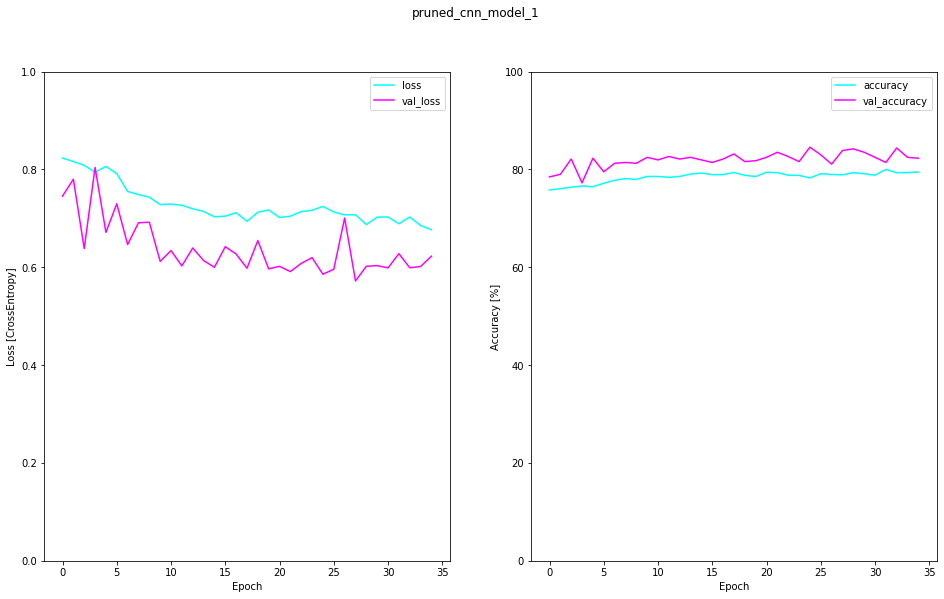

In [76]:

metrics = history.history
fig, axes = plt.subplots(1,2, figsize=(16,9))

axes[0].plot(history.epoch, metrics['loss'], 'cyan', metrics['val_loss'], 'magenta')
axes[0].legend(['loss', 'val_loss'])
axes[0].set_ylim([0, max(plt.ylim())])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss [CrossEntropy]')

fig.suptitle(model_name)

axes[1].plot(history.epoch, 100 *
         np.array(metrics['accuracy']), 'cyan', 100*np.array(metrics['val_accuracy']), 'magenta')
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set_ylim([0, 100])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy [%]')

plt.show()


Model evaluation (optional)

In [77]:
qmodel_pruned.evaluate(test_spectrogram_ds, return_dict=True)


19/19 [==============================] - 1s 16ms/step - loss: 0.6278 - accuracy: 0.8347


{'loss': 0.6278492212295532, 'accuracy': 0.8347386121749878}

Model weight histograms

In [ ]:
def doWeights(model):
    
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Lukumäärä', fontsize=18)
    plt.xlabel('Painokertoimet', fontsize=18)
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.show()
    
doWeights(model)
doWeights(model_pruned) 


Confusion matrix (optional and may have to be reconfigured)

In [ ]:
y_pred = model_pruned.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30, 20))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
